# Image Captioning - Model Training

In this notebook, we will train the image captioning model using the pre-extracted features from the CNN encoder. We will:

1. Set up the data loaders for training and validation
2. Build the caption model (combining the encoder and decoder)
3. Define the training pipeline with teacher forcing
4. Train the model with appropriate hyperparameters
5. Monitor the training progress and validation performance
6. Save the trained model for later evaluation

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import time
import h5py
import random

# Add project root to path
sys.path.append('..')

# Import project modules
from models.encoder import EncoderCNN
from models.decoder import DecoderRNN
from models.caption_model import CaptionModel
from utils.vocabulary import Vocabulary
from utils.dataset import get_data_loaders
from utils.trainer import CaptionTrainer

## 1. Configuration Settings

In [7]:
# Define configuration settings
config = {
    # Data settings
    'data_dir': '../data/flickr8k',
    'batch_size': 32,
    'num_workers': 0,
    
    # Model settings
    'encoder_model': 'resnet18',  # Options: 'resnet18', 'resnet50', 'mobilenet_v2'
    'embed_size': 256,
    'hidden_size': 512,
    'num_layers': 1,
    'dropout': 0.5,
    'decoder_type': 'lstm',  # Options: 'lstm', 'gru'
    
    # Training settings
    'learning_rate': 3e-4,
    'num_epochs': 9,  # Increase for better results
    'early_stopping_patience': 5,
    'save_dir': '../models',
    
    # Device settings
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Create save directory if it doesn't exist
os.makedirs(config['save_dir'], exist_ok=True)

# Print configuration
for section, items in {
    'Data': ['data_dir', 'batch_size', 'num_workers'],
    'Model': ['encoder_model', 'embed_size', 'hidden_size', 'num_layers', 'dropout', 'decoder_type'],
    'Training': ['learning_rate', 'num_epochs', 'early_stopping_patience', 'save_dir'],
    'Device': ['device']
}.items():
    print(f"\n{section} settings:")
    for item in items:
        print(f"  {item}: {config[item]}")


Data settings:
  data_dir: ../data/flickr8k
  batch_size: 32
  num_workers: 0

Model settings:
  encoder_model: resnet18
  embed_size: 256
  hidden_size: 512
  num_layers: 1
  dropout: 0.5
  decoder_type: lstm

Training settings:
  learning_rate: 0.0003
  num_epochs: 9
  early_stopping_patience: 5
  save_dir: ../models

Device settings:
  device: cuda


## 2. Load Data

In [8]:
# Get data loaders
train_loader, val_loader, test_loader, vocab = get_data_loaders(
    data_dir=config['data_dir'],
    batch_size=config['batch_size'],
    num_workers=config['num_workers']
)

# Update vocabulary size in config
config['vocab_size'] = len(vocab)
print(f"Vocabulary size: {config['vocab_size']}")

# Display data loader information
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Vocabulary size: 2986
Training batches: 937
Validation batches: 157
Test batches: 5000


## 3. Create Model

In [9]:
# Create caption model
model = CaptionModel(
    embed_size=config['embed_size'],
    hidden_size=config['hidden_size'],
    vocab_size=config['vocab_size'],
    num_layers=config['num_layers'],
    encoder_model=config['encoder_model'],
    decoder_type=config['decoder_type'],
    dropout=config['dropout'],
    train_encoder=False  # Don't train the encoder (use pre-trained weights)
)

# Print model architecture
print(model)

C:\Users\Aha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Aha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CaptionModel(
  (encoder): EncoderCNN(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batch

In [10]:
# Calculate model size
def count_parameters(model):
    """Count the number of trainable parameters in a model."""
    num_of_trainable_parameters = 0
    for p in model.parameters() : 
        if p.requires_grad:
            num_of_trainable_parameters += p.numel() 
    return num_of_trainable_parameters

# Calculate and print model size
num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params:,} ")

# Calculate encoder and decoder sizes separately
encoder_params = count_parameters(model.encoder)
decoder_params = count_parameters(model.decoder)
print(f"Encoder parameters: {encoder_params:} ({encoder_params / num_params * 100:.1f}%)")
print(f"Decoder parameters: {decoder_params:} ({decoder_params / num_params * 100:.1f}%)")

Number of trainable parameters: 4,005,034 
Encoder parameters: 131840 (3.3%)
Decoder parameters: 3873194 (96.7%)


## 4. Train the Model

In [11]:
trainer = CaptionTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    vocab=vocab,
    device=config['device'],
    learning_rate=config['learning_rate'],
    model_save_dir=config['save_dir']
)

C:\Users\Aha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [12]:
# Train the model
history = trainer.train(
    epochs=config['num_epochs'],
    early_stopping_patience=config['early_stopping_patience'],
    evaluate_every=1,
    generate_every=3 # Generate captions and calculate BLEU every 3 epochs
)

Starting training for 9 epochs...
Training on device: cuda


Epoch 1:   0%|                                                                | 0/937 [10:17<?, ?it/s, Batch Loss=0.74]


Epoch 1 - Train Loss: 1.0066


Validation Epoch 1: 100%|███████████████████████████████████████| 157/157 [01:33<00:00,  1.68it/s, Batch Val Loss=1.06]


Epoch 1 - Val Loss: 0.8332
Model checkpoint saved to ../models\best_model_loss.pth
Epoch 1/9 completed in 711.52s - Train Loss: 1.0066, Val Loss: 0.8332


Epoch 2:   0%|                                                               | 0/937 [10:13<?, ?it/s, Batch Loss=0.808]


Epoch 2 - Train Loss: 0.7694


Validation Epoch 2: 100%|██████████████████████████████████████| 157/157 [01:32<00:00,  1.70it/s, Batch Val Loss=0.942]


Epoch 2 - Val Loss: 0.7619
Model checkpoint saved to ../models\best_model_loss.pth
Epoch 2/9 completed in 706.02s - Train Loss: 0.7694, Val Loss: 0.7619


Epoch 3:   0%|                                                               | 0/937 [10:18<?, ?it/s, Batch Loss=0.725]


Epoch 3 - Train Loss: 0.7078


Generating captions: 100%|███████████████████████████████████████████████████████████| 157/157 [02:46<00:00,  1.06s/it]


hypotheses: black dog is running through the grass
[[['child', 'and', 'woman', 'are', 'at', 'waters', 'edge', 'in', 'big', 'city']], [['large', 'lake', 'with', 'lone', 'duck', 'swimming', 'in', 'it', 'with', 'several', 'people', 'around', 'the', 'edge', 'of', 'it']], [['little', 'boy', 'at', 'lake', 'watching', 'duck']]] [['two', 'people', 'are', 'playing', 'in', 'the', 'water'], ['two', 'people', 'are', 'playing', 'in', 'the', 'water'], ['two', 'people', 'are', 'playing', 'in', 'the', 'water']]
bleu_scores [0.19412160674769985, 0.09708470481345488, 0.05016327506185849, 0.02688110491352896]
Epoch 3 - Val Loss: 0.7292, BLEU-4: 0.0269
Model checkpoint saved to ../models\best_model_loss.pth
Model checkpoint saved to ../models\best_model_bleu.pth
Epoch 3/9 completed in 881.92s - Train Loss: 0.7078, Val Loss: 0.7292, BLEU-4: 0.0269


Epoch 4:   0%|                                                               | 0/937 [10:21<?, ?it/s, Batch Loss=0.632]


Epoch 4 - Train Loss: 0.6691


Validation Epoch 4: 100%|██████████████████████████████████████| 157/157 [01:33<00:00,  1.68it/s, Batch Val Loss=0.887]


Epoch 4 - Val Loss: 0.7097
Model checkpoint saved to ../models\best_model_loss.pth
Epoch 4/9 completed in 714.91s - Train Loss: 0.6691, Val Loss: 0.7097


Epoch 5:   0%|                                                             | 0/937 [6:59:45<?, ?it/s, Batch Loss=0.691]

KeyboardInterrupt: 

## 5. Analyze Training Results

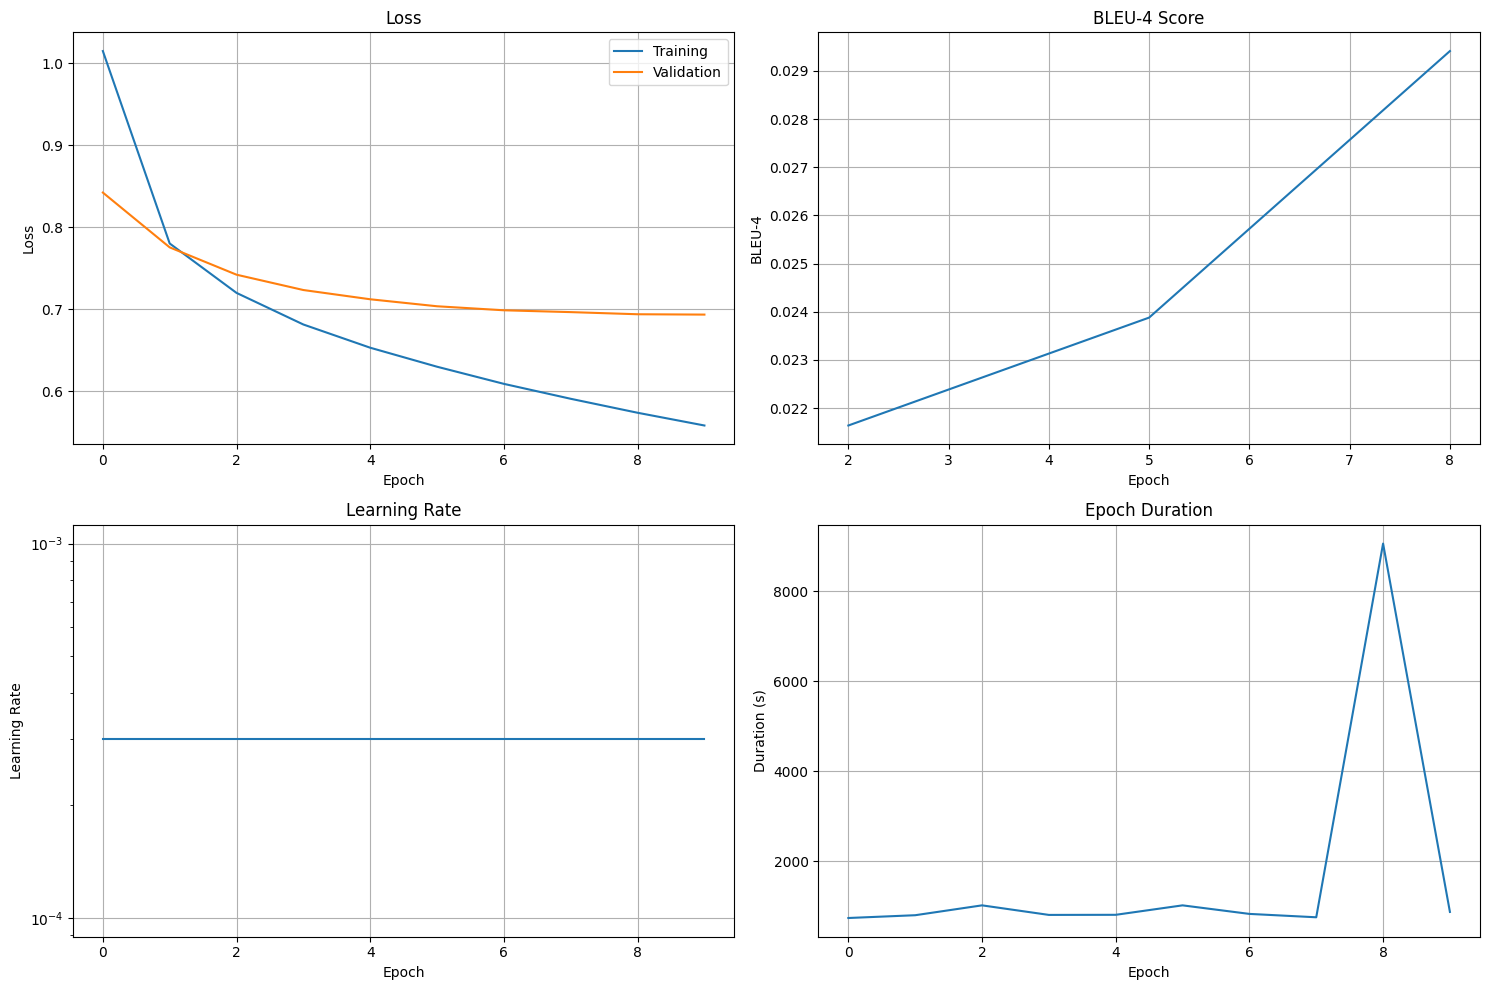

In [8]:
# Plot training history
fig, axs = trainer.plot_history()
plt.show()

In [9]:
# Find best epoch
best_epoch = np.argmin(trainer.history['val_loss'])
print(f"Best epoch: {best_epoch + 1}")
print(f"Best validation loss: {trainer.history['val_loss'][best_epoch]:.4f}")

# If BLEU scores were calculated
bleu_epochs = [i for i, bleu in enumerate(trainer.history['val_bleu']) if bleu > 0]
if bleu_epochs:
    best_bleu_epoch = bleu_epochs[np.argmax([trainer.history['val_bleu'][i] for i in bleu_epochs])]
    print(f"Best BLEU epoch: {best_bleu_epoch + 1}")
    print(f"Best BLEU score: {trainer.history['val_bleu'][best_bleu_epoch]:.4f}")

Best epoch: 10
Best validation loss: 0.6935
Best BLEU epoch: 9
Best BLEU score: 0.0294


## 6. Generate Sample Captions

In [10]:
# Load the best model
best_model_path = os.path.join(config['save_dir'], 'best_model_loss.pth')
trainer.load_checkpoint(best_model_path)
model = trainer.model.to(config['device'])

Loaded checkpoint from ../models\best_model_loss.pth (epoch 10)


In [11]:
#trainer.validate(True)

20


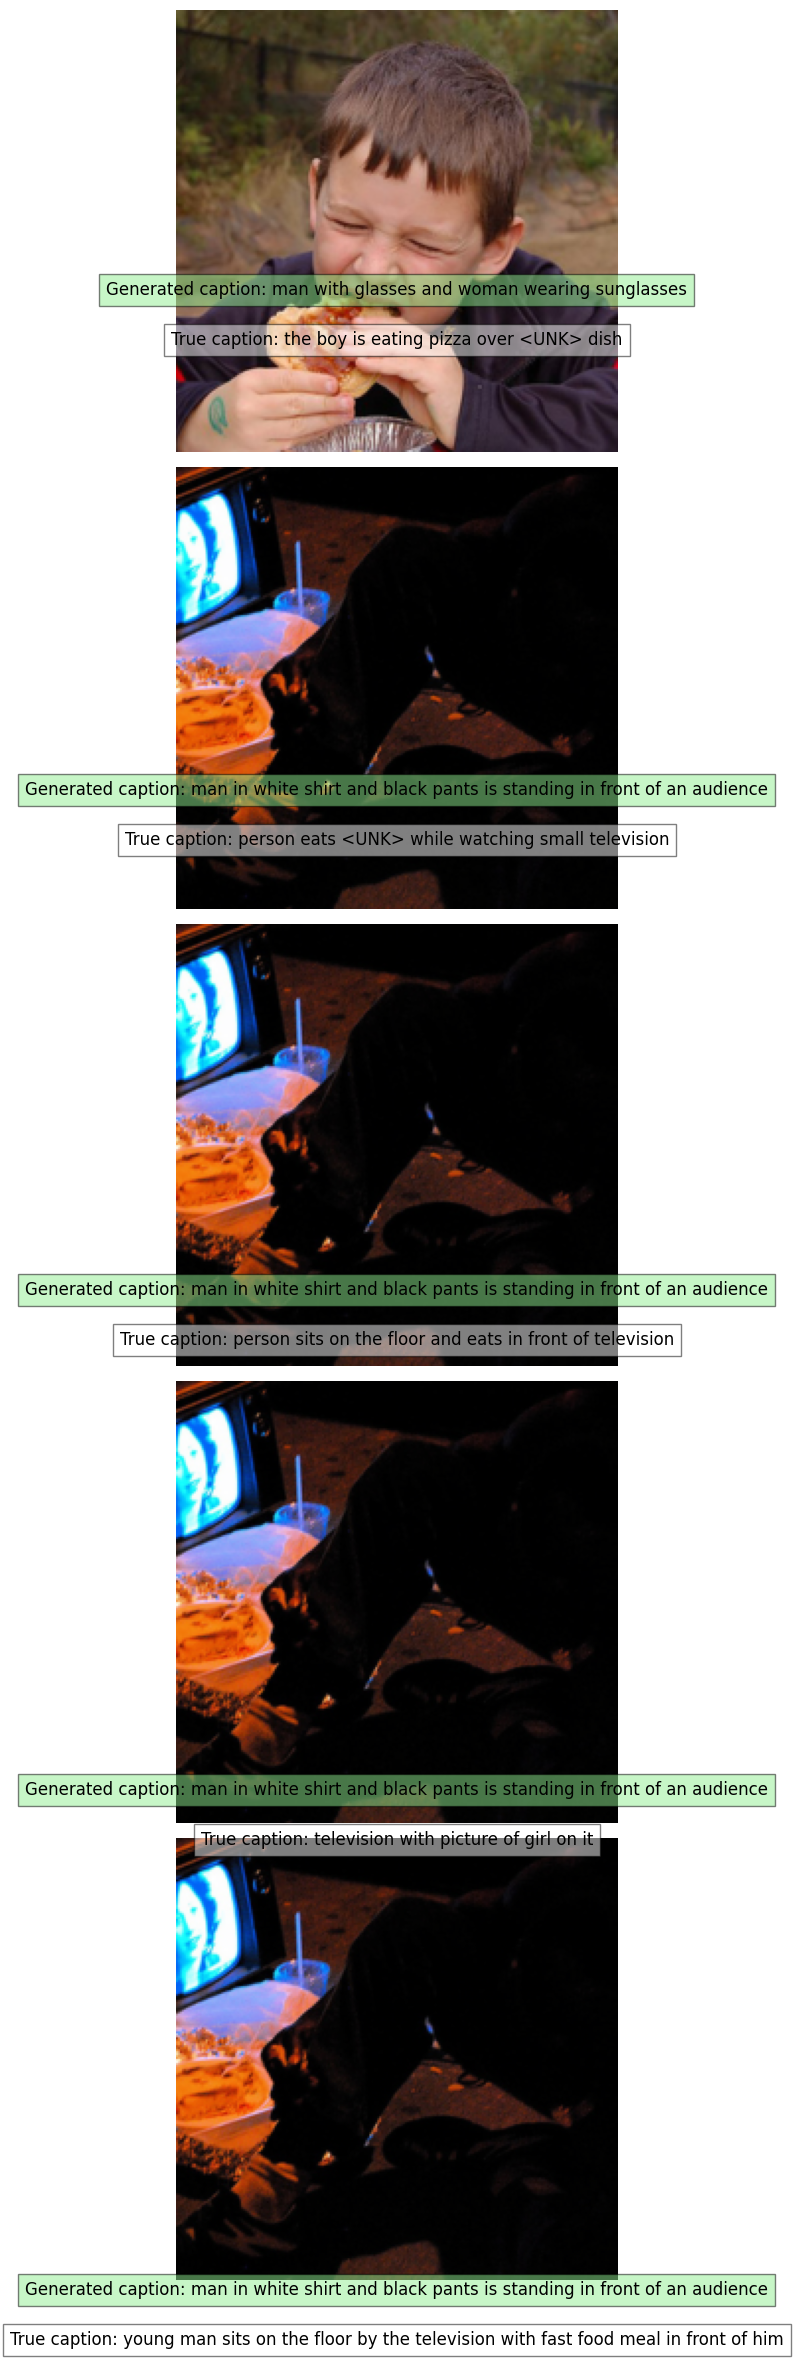

In [12]:
# Generate captions for some validation images
def generate_caption(image, model, vocab, device):
    """Generate a caption for an image."""
    image = image.unsqueeze(0).to(device)

    model.eval()
    predicted_ids = model.generate_caption(
                    image,
                    beam_size=1
                )

    # Decode generated caption
    caption_text = vocab.decode(predicted_ids[0].tolist(), join=True, remove_special=True)

    
    return caption_text

# Get some validation examples
num_examples = 5
skip_examples = random.randint(0, 100) 
val_examples = []
example_count = 0 
print(skip_examples)
for images, captions in val_loader:
    if len(val_examples) >= num_examples:
        break
    
    # Generate captions
    for i in range(len(images)):
        example_count += 1 
        if example_count < skip_examples: 
            continue
        if len(val_examples) >= num_examples:
            break
        
        image = images[i]
        true_caption = vocab.decode(captions[i], join=True, remove_special=True)
        generated_caption = generate_caption(image, model, vocab, config['device'])
        
        val_examples.append({
            'image': image,
            #'image_id': image_ids[i],
            'true_caption': true_caption,
            'generated_caption': generated_caption
        })

# Display examples
plt.figure(figsize=(15, 5 * num_examples))

for i, example in enumerate(val_examples):
    plt.subplot(num_examples, 1, i + 1)
    
    # Convert tensor to image
    img = example['image'].permute(1, 2, 0).numpy()
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    #plt.title(f"Image: {example['image_id']}")
    plt.axis('off')
    plt.figtext(0.5, 0.01 + (num_examples - i - 1) * (1/num_examples), f"True caption: {example['true_caption']}", 
                ha='center', fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    plt.figtext(0.5, 0.03 + (num_examples - i - 1) * (1/num_examples), f"Generated caption: {example['generated_caption']}", 
                ha='center', fontsize=12, bbox={"facecolor":"lightgreen", "alpha":0.5, "pad":5})

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 7. Compare Greedy and Beam Search Decoding

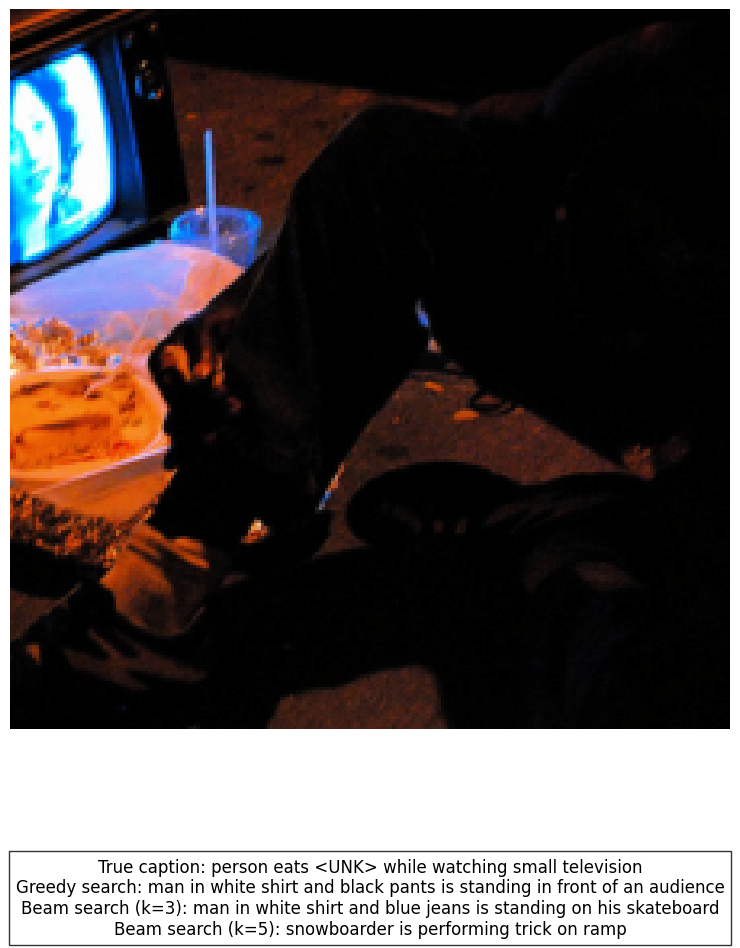

In [13]:
# Compare greedy decoding vs. beam search
def compare_decoding_methods(image, model, vocab, device, beam_sizes=[1, 3, 5]):
    """Compare different beam search sizes for caption generation."""
    results = {}
    # TODO: Implement a function to compare different beam search settings
    # 1. Set the model to evaluation mode
    # 2. Initialize a dictionary to store results
    # 3. For each beam size:
    #    a. Generate a caption using that beam size
    #    b. Decode the caption indices to text
    #    c. Store the result in the dictionary
    # 4. Return the dictionary of results

    model.eval()
    
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    for beam_size in beam_sizes:
        with torch.no_grad():
            caption_ids = model.generate_caption(image, max_length=20, beam_size = beam_size)
        
        caption=  vocab.decode(caption_ids[0].cpu().numpy()) 
        
        
        results[f'beam_{beam_size}'] = caption
    
    return results



# Select a random example from val_examples

example = random.choice(val_examples)

# Compare decoding methods
beam_results = compare_decoding_methods(
    example['image'], 
    model, 
    vocab, 
    config['device'], 
    beam_sizes=[1, 3, 5]
)

# Display the image with different captions
plt.figure(figsize=(10, 10))

# Display image
img = example['image'].permute(1, 2, 0).numpy()
img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.axis('off')
#plt.title(f"Image: {example['image_id']}")

# Add captions
captions = [
    f"True caption: {example['true_caption']}",
    f"Greedy search: {beam_results['beam_1']}",
    f"Beam search (k=3): {beam_results['beam_3']}",
    f"Beam search (k=5): {beam_results['beam_5']}"
]

# Display captions below the image
plt.figtext(0.5, 0.01, '\n'.join(captions), ha='center', fontsize=12, 
            bbox={"facecolor":"white", "alpha":0.8, "pad":5})

plt.tight_layout(rect=[0, 0.2, 1, 0.95])
plt.show()

## 8. Save Final Model and Configuration

In [14]:
# Save configuration
import json
config_path = os.path.join(config['save_dir'], 'config.json')

# Convert non-serializable values to strings
serializable_config = {k: str(v) if not isinstance(v, (int, float, str, bool)) else v 
                      for k, v in config.items()}

with open(config_path, 'w') as f:
    json.dump(serializable_config, f, indent=4)

print(f"Configuration saved to {config_path}")

Configuration saved to ../models\config.json


In [14]:
# Save vocabulary separately for easy access
import pickle
vocab_path = os.path.join(config['save_dir'], 'vocabulary.pkl')
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)

print(f"Vocabulary saved to {vocab_path}")

Vocabulary saved to ../models\vocabulary.pkl


## Summary

In this notebook, we have successfully:

1. Set up the data loaders for training and validation
2. Built the caption model by combining the encoder and decoder
3. Trained the model with teacher forcing
4. Monitored the training progress and validation performance
5. Generated captions for sample images
6. Compared different decoding strategies (greedy vs. beam search)
7. Saved the model, configuration, and vocabulary for later use

In the next notebook, we will perform a comprehensive evaluation of the model on the test set.